In [97]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from autoencoder import create_encoders, create_conv_encoders, fit_encoders, create_full_model, fit_full_model, create_fc_layers
from preprocess import load_clean_data, data_stats, plot_samples, plot_avg, plot_ewma, create_features, create_features_labels 
from plots import plot_validation_diagram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
data = load_clean_data([0, 1])
validation = load_clean_data([3])

In [289]:
#data_stats(data)

In [158]:
#plot_samples(data)

In [159]:
#plot_avg(data[0]['signals'], 400)

In [160]:
#plot_ewma(data[0]['signals'], 400)

In [48]:
beats = create_features(data, 784)
x_train_beats, x_test_beats = train_test_split(beats, test_size = 0.2, random_state = 0)
features, labels = create_features_labels(data, 784, non_beats_per_beat=2)
lb = LabelBinarizer()
bin_labels = lb.fit_transform(labels)
x_train, x_test, y_train, y_test = train_test_split(features, bin_labels, test_size = 0.2, random_state = 0)

In [5]:
print(lb.classes_)

['A' 'N' 'NB']


In [151]:
ann = data[0]['annotations']
sig = data[0]['signals']

In [130]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [131]:
ann[ann['Type'] == 'A']

,Time,Sample,Type
1357,19:21.875,418275,A
1588,22:40.108,489639,A


In [106]:
def evaluate_fc(encoder, config, epochs = 2):
    models = []
    for layers_dim in config:
        print('Evaluating model with fc:', layers_dim)
        model = create_full_model(encoder, layers_dim)        
        models.append(model)
        fit_full_model(model, x_train, x_test, y_train, y_test, epochs=epochs, verbose=0)
        plot_validation_diagram(model, lb.classes_, ann, sig, 500, 2500)        
        
    return models

In [84]:
encoders = create_encoders(784, [], 64)

Successfully loaded weights


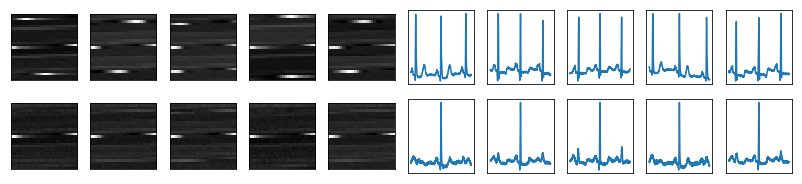

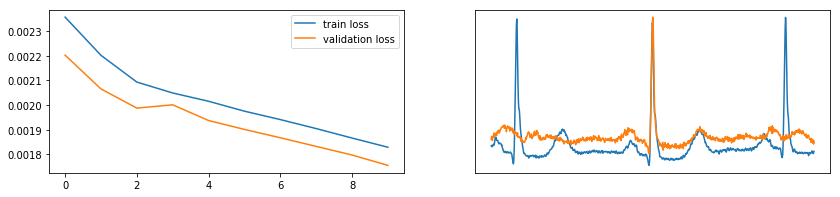

In [28]:
h = fit_encoders(encoders, x_train_beats, x_test_beats, epochs=10, filename='784_64.h5', load_prev=True)

In [85]:
#full_model = create_full_model(encoders[1], layers_dim=[64, 3])
#fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=100, verbose=0)
#plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

Evaluating model with fc: [3]


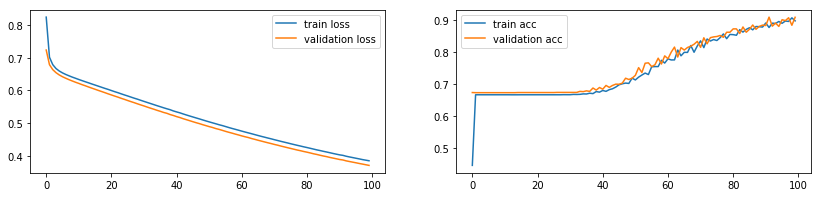

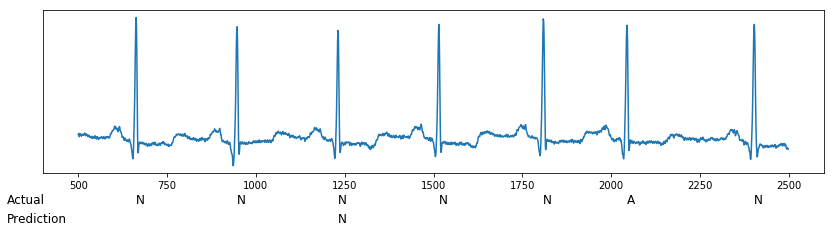

Evaluating model with fc: [10, 3]


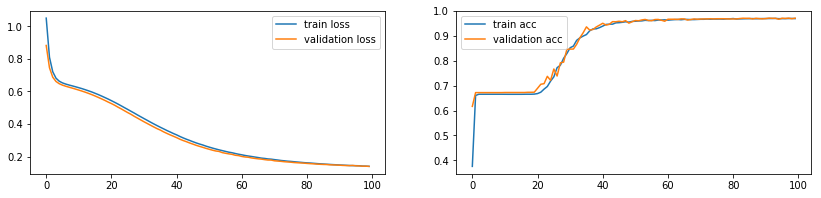

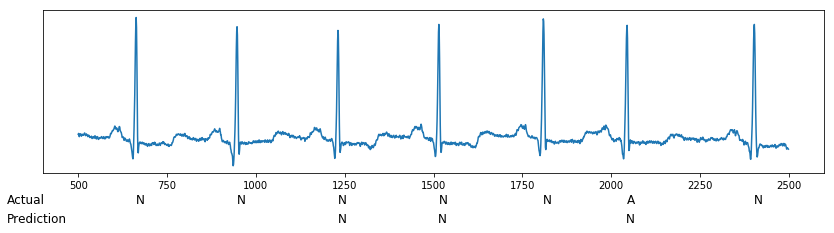

Evaluating model with fc: [32, 3]


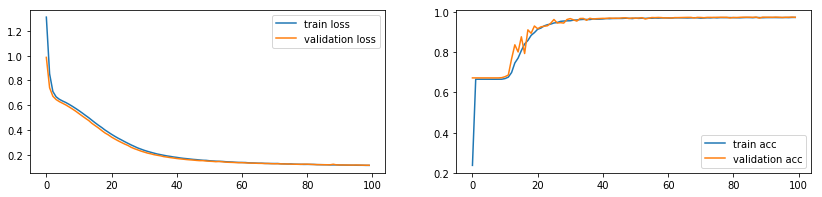

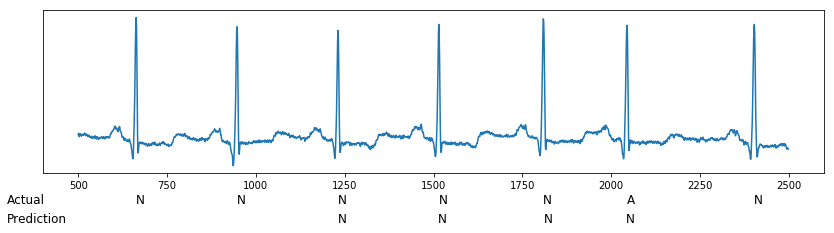

Evaluating model with fc: [64, 3]


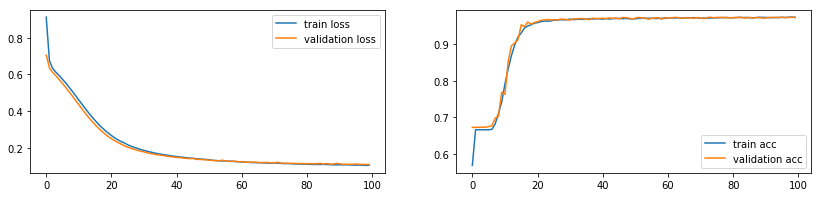

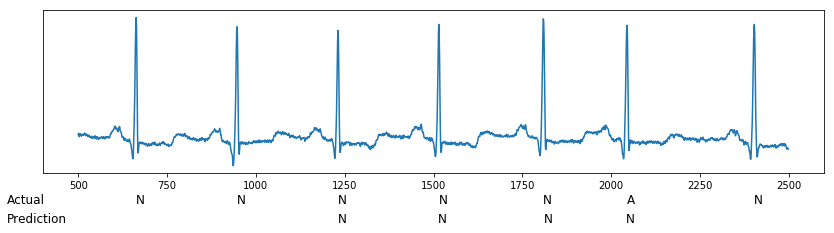

In [107]:
r = evaluate_fc(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### 784 256 128 64

In [108]:
encoders = create_encoders(784, [256, 128], 64)

Successfully loaded weights


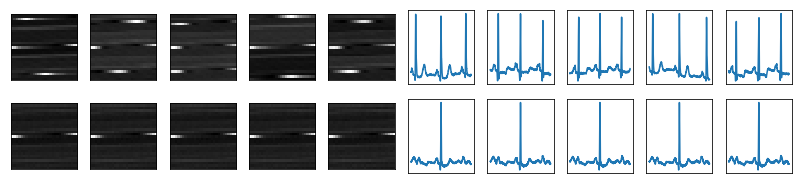

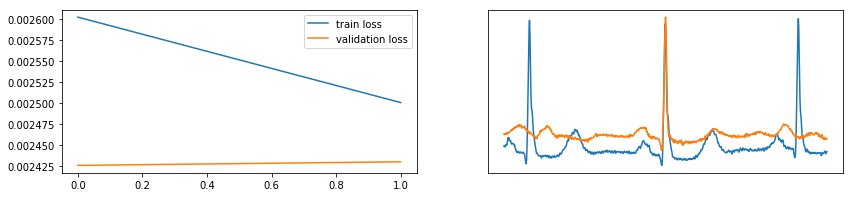

In [109]:
h = fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='784_256_128_64.h5', load_prev=True)

Evaluating model with fc: [3]


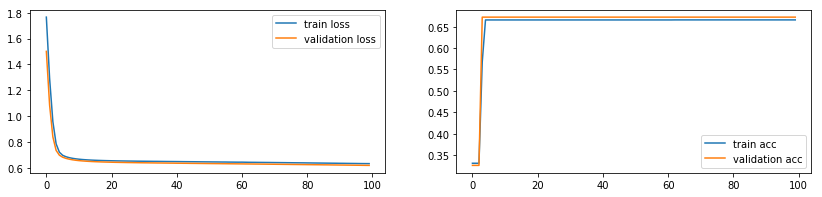

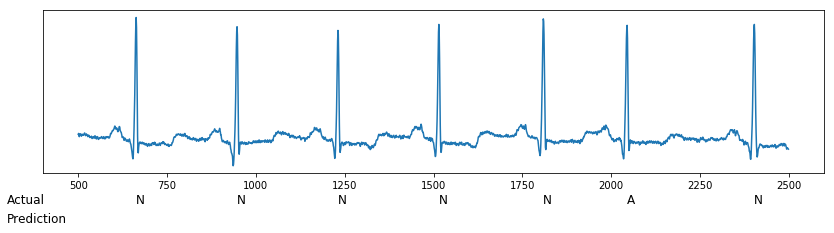

Evaluating model with fc: [10, 3]


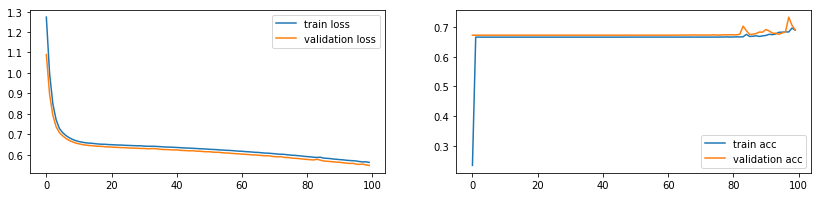

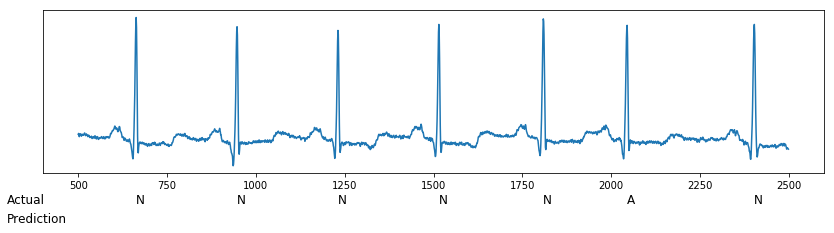

Evaluating model with fc: [32, 3]


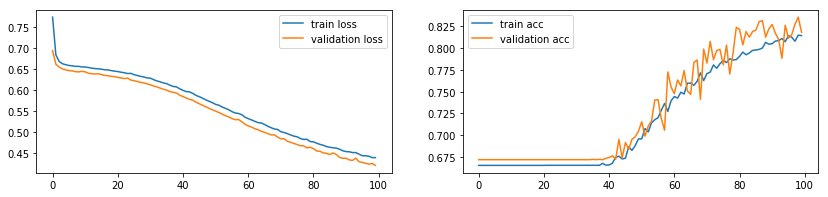

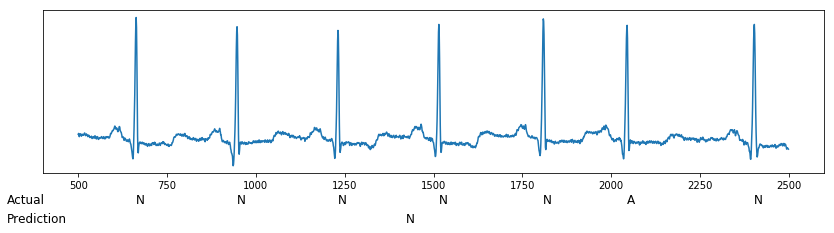

Evaluating model with fc: [64, 3]


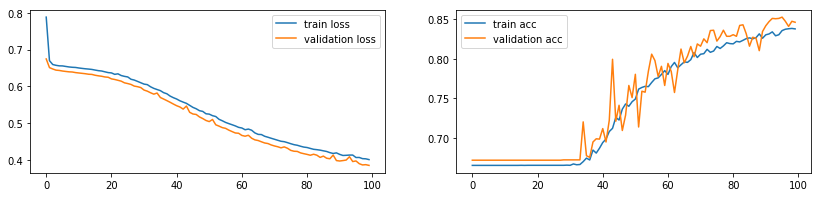

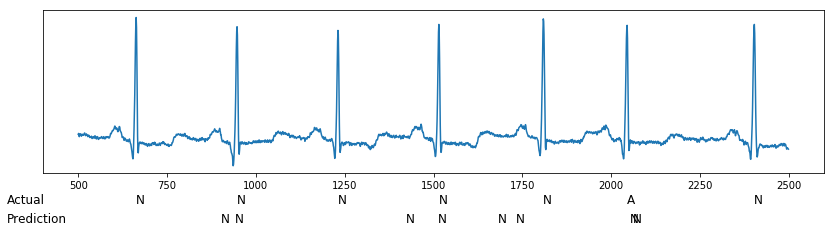

In [110]:
r = evaluate_fc(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### 784 512 64

In [114]:
encoders = create_encoders(784, [512], 64)

Successfully loaded weights


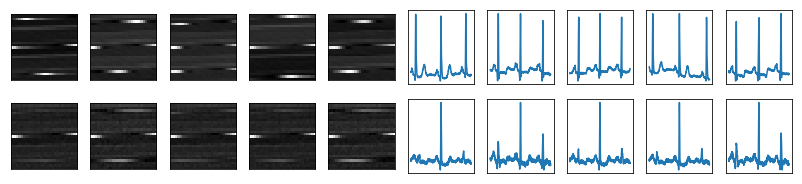

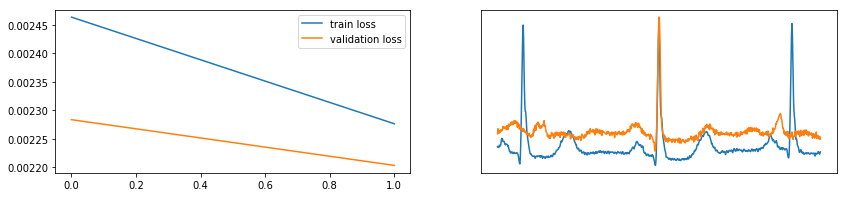

In [112]:
fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='784_512_64.h5', load_prev=True)

Evaluating model with fc: [3]


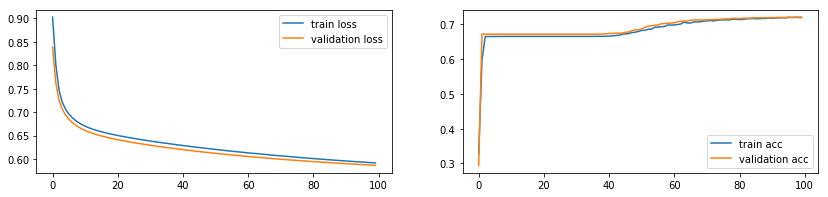

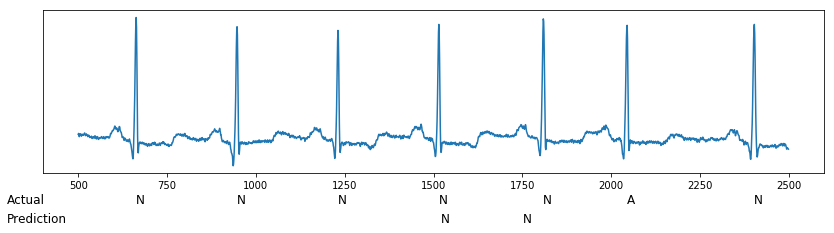

Evaluating model with fc: [10, 3]


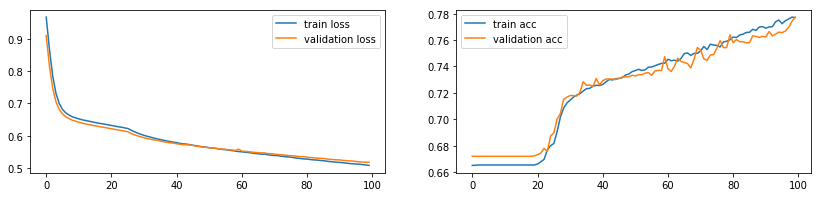

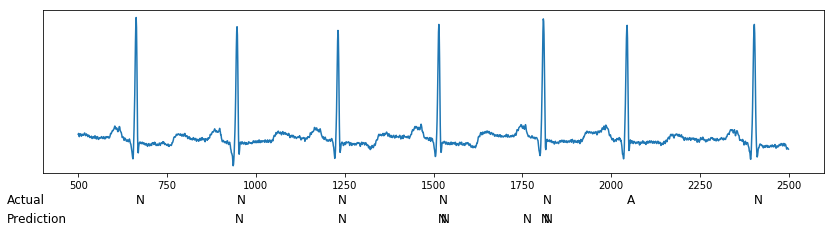

Evaluating model with fc: [32, 3]


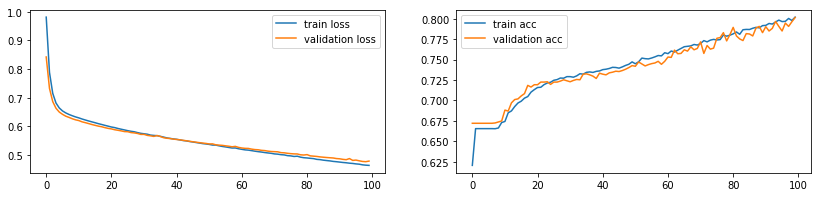

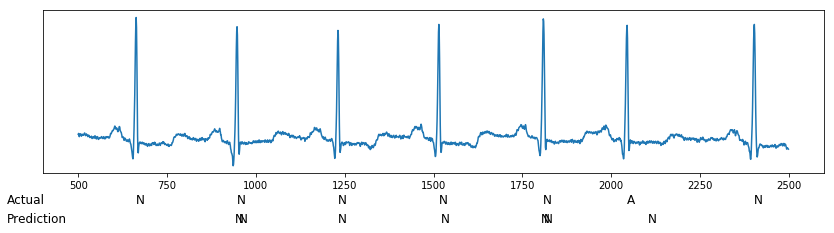

Evaluating model with fc: [64, 3]


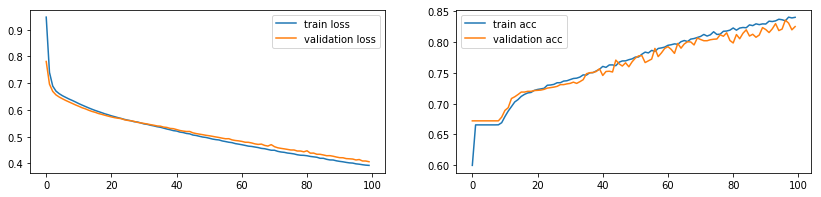

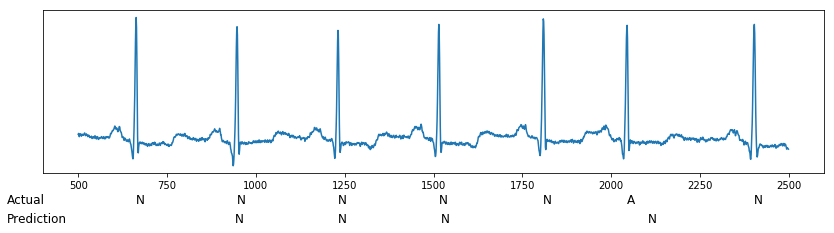

In [113]:
r = evaluate_fc(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### CONV

In [115]:
encoders = create_conv_encoders()

Successfully loaded weights
Train on 3303 samples, validate on 826 samples
Epoch 1/200
3303/3303 [==============================] - 2s - loss: 0.0016 - acc: 3.0893e-06 - val_loss: 0.0039 - val_acc: 3.0884e-06
Epoch 2/200
3303/3303 [==============================] - 1s - loss: 0.0015 - acc: 3.0893e-06 - val_loss: 0.0039 - val_acc: 3.0884e-06
Epoch 3/200
3303/3303 [==============================] - 1s - loss: 0.0015 - acc: 3.0893e-06 - val_loss: 0.0039 - val_acc: 3.0884e-06
Epoch 4/200
3303/3303 [==============================] - 1s - loss: 0.0014 - acc: 3.0893e-06 - val_loss: 0.0038 - val_acc: 3.0884e-06
Epoch 5/200
3303/3303 [==============================] - 1s - loss: 0.0014 - acc: 3.0893e-06 - val_loss: 0.0039 - val_acc: 3.0884e-06
Epoch 6/200
3303/3303 [==============================] - 1s - loss: 0.0014 - acc: 3.0893e-06 - val_loss: 0.0040 - val_acc: 3.0884e-06
Epoch 7/200
3303/3303 [==============================] - 1s - loss: 0.0014 - acc: 3.0893e-06 - val_loss: 0.0039 - val_acc

3303/3303 [==============================] - 1s - loss: 7.5415e-04 - acc: 3.0893e-06 - val_loss: 0.0018 - val_acc: 3.0884e-06
Epoch 61/200
3303/3303 [==============================] - 1s - loss: 7.4259e-04 - acc: 3.0893e-06 - val_loss: 0.0015 - val_acc: 3.0884e-06
Epoch 62/200
3303/3303 [==============================] - 1s - loss: 7.3826e-04 - acc: 3.0893e-06 - val_loss: 0.0015 - val_acc: 3.0884e-06
Epoch 63/200
3303/3303 [==============================] - 1s - loss: 7.2908e-04 - acc: 3.0893e-06 - val_loss: 0.0015 - val_acc: 3.0884e-06
Epoch 64/200
3303/3303 [==============================] - 1s - loss: 7.3143e-04 - acc: 3.0893e-06 - val_loss: 0.0016 - val_acc: 3.0884e-06
Epoch 65/200
3303/3303 [==============================] - 1s - loss: 7.2014e-04 - acc: 3.0893e-06 - val_loss: 0.0019 - val_acc: 3.0884e-06
Epoch 66/200
3303/3303 [==============================] - 1s - loss: 7.2669e-04 - acc: 3.0893e-06 - val_loss: 0.0016 - val_acc: 3.0884e-06
Epoch 67/200
3303/3303 [================

3303/3303 [==============================] - 1s - loss: 5.3883e-04 - acc: 3.4755e-06 - val_loss: 6.2623e-04 - val_acc: 3.0884e-06
Epoch 118/200
3303/3303 [==============================] - 1s - loss: 5.4122e-04 - acc: 3.4755e-06 - val_loss: 5.6116e-04 - val_acc: 3.0884e-06
Epoch 119/200
3303/3303 [==============================] - 1s - loss: 5.4840e-04 - acc: 3.4755e-06 - val_loss: 5.8193e-04 - val_acc: 3.0884e-06
Epoch 120/200
3303/3303 [==============================] - 1s - loss: 5.4084e-04 - acc: 3.4755e-06 - val_loss: 6.1170e-04 - val_acc: 3.0884e-06
Epoch 121/200
3303/3303 [==============================] - 1s - loss: 5.3763e-04 - acc: 3.4755e-06 - val_loss: 7.5811e-04 - val_acc: 3.0884e-06
Epoch 122/200
3303/3303 [==============================] - 1s - loss: 5.4396e-04 - acc: 3.4755e-06 - val_loss: 6.8507e-04 - val_acc: 3.0884e-06
Epoch 123/200
3303/3303 [==============================] - 1s - loss: 5.3835e-04 - acc: 3.4755e-06 - val_loss: 8.8411e-04 - val_acc: 3.0884e-06
Epoch 

3303/3303 [==============================] - 1s - loss: 4.7110e-04 - acc: 3.4755e-06 - val_loss: 4.4398e-04 - val_acc: 3.0884e-06
Epoch 175/200
3303/3303 [==============================] - 1s - loss: 4.8352e-04 - acc: 3.4755e-06 - val_loss: 4.4720e-04 - val_acc: 3.0884e-06
Epoch 176/200
3303/3303 [==============================] - 1s - loss: 4.5649e-04 - acc: 3.4755e-06 - val_loss: 4.5827e-04 - val_acc: 3.0884e-06
Epoch 177/200
3303/3303 [==============================] - 1s - loss: 4.6343e-04 - acc: 3.4755e-06 - val_loss: 5.2576e-04 - val_acc: 3.0884e-06
Epoch 178/200
3303/3303 [==============================] - 1s - loss: 4.5994e-04 - acc: 3.4755e-06 - val_loss: 5.0564e-04 - val_acc: 3.0884e-06
Epoch 179/200
3303/3303 [==============================] - 1s - loss: 4.5318e-04 - acc: 3.4755e-06 - val_loss: 5.4136e-04 - val_acc: 3.0884e-06
Epoch 180/200
3303/3303 [==============================] - 1s - loss: 4.5490e-04 - acc: 3.4755e-06 - val_loss: 6.3095e-04 - val_acc: 3.0884e-06
Epoch 

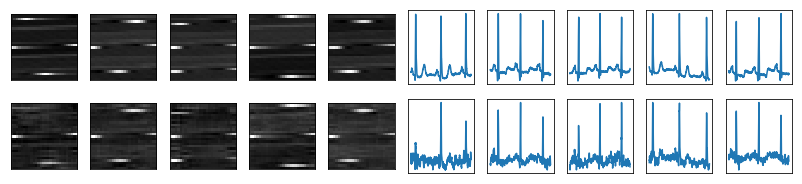

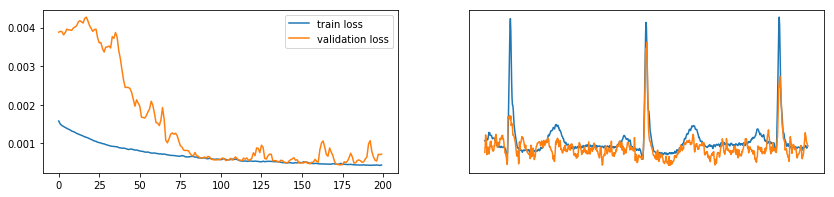

In [116]:
h=fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='bn_conv16_8_8.h5', load_prev=True, verbose=1)

Evaluating model with fc: [3]


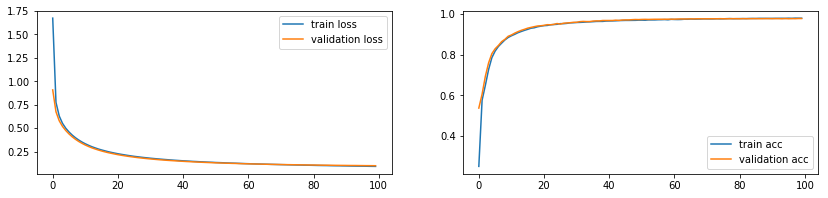

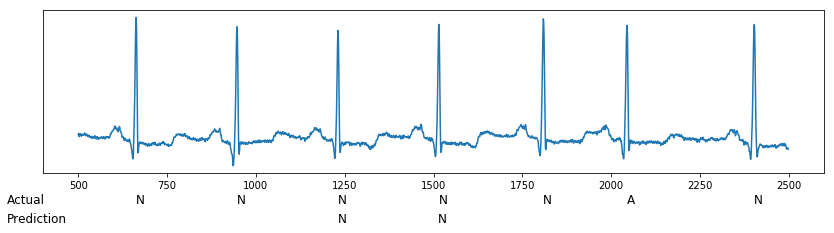

Evaluating model with fc: [10, 3]


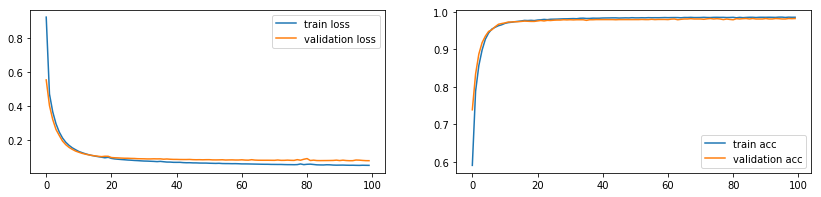

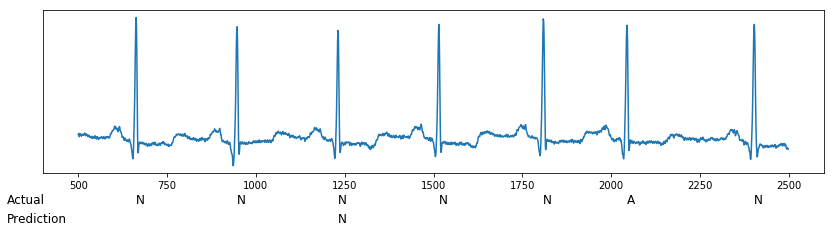

Evaluating model with fc: [32, 3]


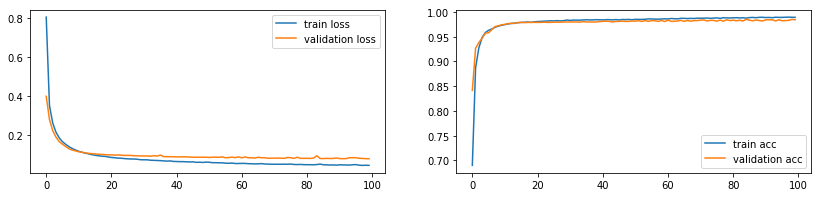

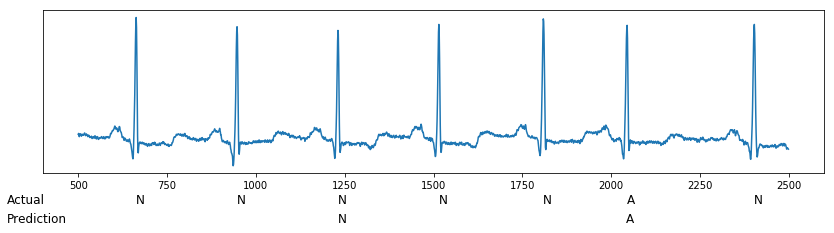

Evaluating model with fc: [64, 3]


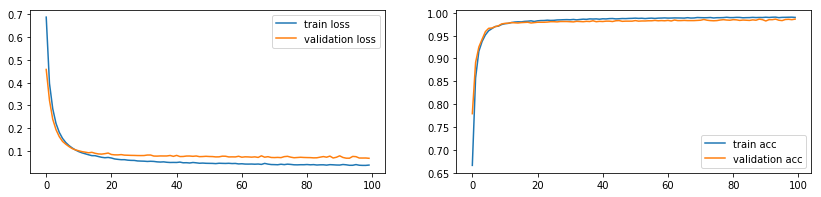

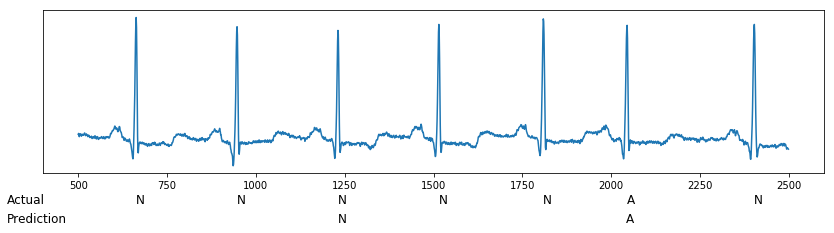

In [118]:
r = evaluate_fc(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

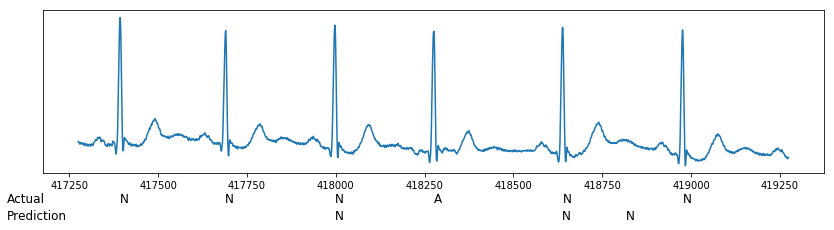

In [150]:
plot_validation_diagram(r[-1], lb.classes_, ann, sig, 418275-1000, 418275 + 1000) 

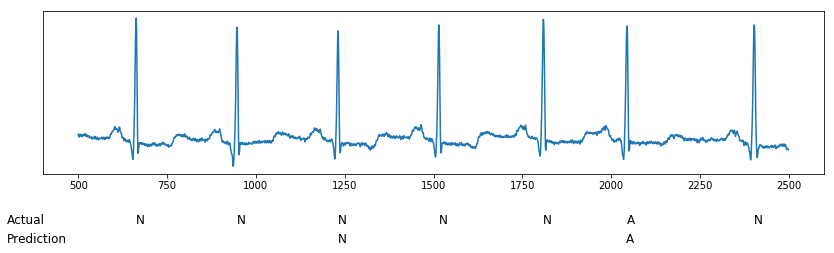

In [153]:
plot_validation_diagram(r[-1], lb.classes_, ann, sig, 500, 2500) 

### Smooth data and bn

Can't load weights to model Unable to open file (Unable to open file: name = 'bn_smooth_data.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0084
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0082
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0080
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0080
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0079
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0079
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0078
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0078
Epoch 9/1000
2

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0037
Epoch 85/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 86/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 87/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 88/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0035
Epoch 89/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 90/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 91/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 92/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 93/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 94/1000
2235/2235 [=============================

2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 253/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 254/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 255/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 256/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 257/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 258/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 259/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 260/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 261/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 262/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 421/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 422/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 423/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 424/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 425/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 426/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 427/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 428/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 429/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 430/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 9.1158e-04 - val_loss: 9.1698e-04
Epoch 581/1000
2235/2235 [==============================] - 0s - loss: 9.1125e-04 - val_loss: 9.1629e-04
Epoch 582/1000
2235/2235 [==============================] - 0s - loss: 9.1033e-04 - val_loss: 9.1134e-04
Epoch 583/1000
2235/2235 [==============================] - 0s - loss: 9.0921e-04 - val_loss: 9.1801e-04
Epoch 584/1000
2235/2235 [==============================] - 0s - loss: 9.0861e-04 - val_loss: 9.1092e-04
Epoch 585/1000
2235/2235 [==============================] - 0s - loss: 9.0807e-04 - val_loss: 9.1028e-04
Epoch 586/1000
2235/2235 [==============================] - 0s - loss: 9.0717e-04 - val_loss: 9.1201e-04
Epoch 587/1000
2235/2235 [==============================] - 0s - loss: 9.0602e-04 - val_loss: 9.1479e-04
Epoch 588/1000
2235/2235 [==============================] - 0s - loss: 9.0521e-04 - val_loss: 9.1107e-04
Epoch 589/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 8.0933e-04 - val_loss: 8.1062e-04
Epoch 737/1000
2235/2235 [==============================] - 0s - loss: 8.0885e-04 - val_loss: 8.1080e-04
Epoch 738/1000
2235/2235 [==============================] - 0s - loss: 8.0818e-04 - val_loss: 8.1295e-04
Epoch 739/1000
2235/2235 [==============================] - 0s - loss: 8.0765e-04 - val_loss: 8.0920e-04
Epoch 740/1000
2235/2235 [==============================] - 0s - loss: 8.0735e-04 - val_loss: 8.0786e-04
Epoch 741/1000
2235/2235 [==============================] - 0s - loss: 8.0657e-04 - val_loss: 8.0956e-04
Epoch 742/1000
2235/2235 [==============================] - 0s - loss: 8.0615e-04 - val_loss: 8.0733e-04
Epoch 743/1000
2235/2235 [==============================] - 0s - loss: 8.0540e-04 - val_loss: 8.1024e-04
Epoch 744/1000
2235/2235 [==============================] - 0s - loss: 8.0509e-04 - val_loss: 8.0603e-04
Epoch 745/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.3131e-04 - val_loss: 7.3064e-04
Epoch 893/1000
2235/2235 [==============================] - 0s - loss: 7.3046e-04 - val_loss: 7.3061e-04
Epoch 894/1000
2235/2235 [==============================] - 0s - loss: 7.2993e-04 - val_loss: 7.2975e-04
Epoch 895/1000
2235/2235 [==============================] - 0s - loss: 7.2927e-04 - val_loss: 7.3114e-04
Epoch 896/1000
2235/2235 [==============================] - 0s - loss: 7.2912e-04 - val_loss: 7.3010e-04
Epoch 897/1000
2235/2235 [==============================] - 0s - loss: 7.2835e-04 - val_loss: 7.2863e-04
Epoch 898/1000
2235/2235 [==============================] - 0s - loss: 7.2820e-04 - val_loss: 7.2792e-04
Epoch 899/1000
2235/2235 [==============================] - 0s - loss: 7.2780e-04 - val_loss: 7.2789e-04
Epoch 900/1000
2235/2235 [==============================] - 0s - loss: 7.2720e-04 - val_loss: 7.2774e-04
Epoch 901/1000
2235/2235 [==============================] - 0s - loss:

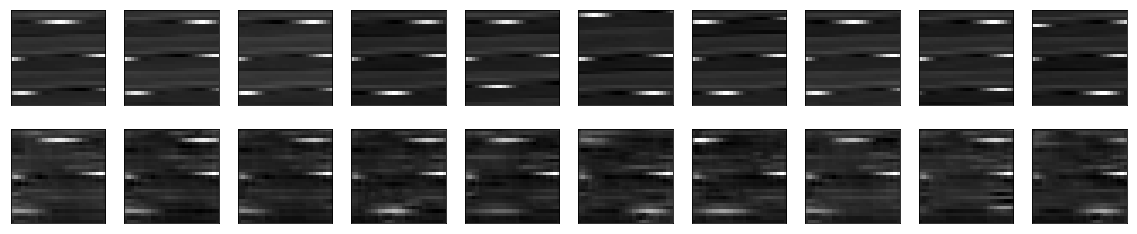

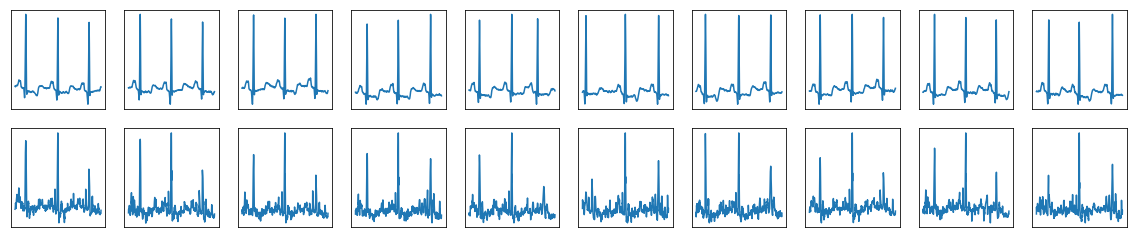

CPU times: user 10min 59s, sys: 1min 43s, total: 12min 43s
Wall time: 13min 32s


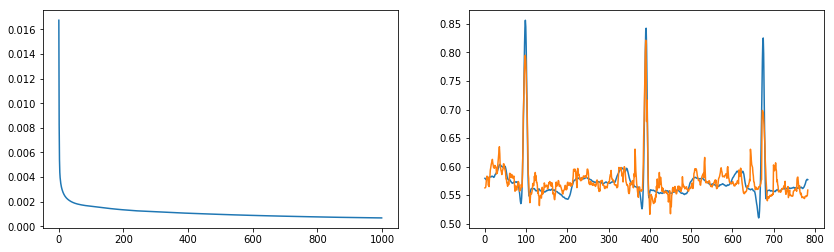

In [64]:
%time run(*create_conv_encoders(), shape=(28,28,1), weights_filename = 'bn_smooth_data.h5', epochs=1000)